In [1]:
import allel
import numpy as np
import pandas as pd
from functools import reduce
import pprint

In [2]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy import nan

In [3]:
from xgboost import XGBClassifier

In [4]:
final_target_features = {'freebayes': ['SOMATIC', 'QUAL', 'ID', 'QR', 'DPB', 'CHROM', 'POS', 'is_snp'],
 'mutect2': ['FILTER_PASS','ID','ECNT','MQ','FILTER_t_lod_fstar','HCNT','DP','CHROM','POS','is_snp',],
 'vardict': ['FILTER_PASS','STATUS','ID','SSF','VD','SOMATIC','CHROM','POS','is_snp'],
 'varscan': ['SOMATIC', 'ID', 'SPV', 'FILTER_PASS', 'CHROM', 'POS', 'is_snp']}


In [5]:
# training with new paramters 

real1_varscan_sub = allel.vcf_to_dataframe("real1/real1-varscan.vcf.gz", fields = final_target_features['varscan'])

real1_freebayes_sub = allel.vcf_to_dataframe("real1/real1-freebayes.vcf.gz", fields = final_target_features['freebayes'])

real1_mutect2_sub = allel.vcf_to_dataframe("real1/real1-mutect2.vcf.gz", fields =final_target_features['mutect2'])

real1_vardict_sub = allel.vcf_to_dataframe("real1/real1-vardict.vcf.gz", fields = final_target_features['vardict'])

In [6]:
# subsetting for snp = True 
varscan_sub = real1_varscan_sub[real1_varscan_sub.is_snp == True]
freebayes_sub = real1_freebayes_sub[real1_freebayes_sub.is_snp == True]
mutect2_sub = real1_mutect2_sub[real1_mutect2_sub.is_snp == True]
vardict_sub = real1_vardict_sub[real1_vardict_sub.is_snp == True]

In [7]:
lst_dfs = [varscan_sub,freebayes_sub,mutect2_sub,vardict_sub]
suffix = ['vs','fb','m2','vd']
keep_same = {'CHROM', 'POS'}
i =0 
for df in lst_dfs:
    df.columns = ['{}{}'.format(c, '' if c in keep_same else '_'+suffix[i]) for c in df.columns]
    i += 1
lst_dfs

[      SOMATIC_vs        ID_vs        SPV_vs  FILTER_PASS_vs       CHROM  \
 7          False  rs199706086  5.229100e-01           False           1   
 8          False  rs145427775  6.083900e-01           False           1   
 10         False   rs58108140  6.890800e-01           False           1   
 11         False   rs62635284  7.524200e-01           False           1   
 12         False            .  3.304300e-01           False           1   
 ...          ...          ...           ...             ...         ...   
 5244       False            .  5.133700e-01           False  GL000192.1   
 5246       False            .  6.664900e-04           False  GL000192.1   
 5247       False            .  2.069300e-04           False  GL000192.1   
 5249       False            .  1.121500e-09           False  GL000192.1   
 5250       False            .  2.301600e-02           False  GL000192.1   
 
          POS  is_snp_vs  
 7      10250       True  
 8      10291       True  
 10  

In [8]:
merged_df = reduce(lambda left, right: pd.merge(left, right,on =['CHROM', 'POS'],
                                            how = 'outer', suffixes = ('', '')),lst_dfs)
merged_df = merged_df.drop(['is_snp_vd','is_snp_fb','is_snp_m2','is_snp_vs'], axis=1)
 
merged_df.to_csv("real1_mergered_df.csv")

In [9]:
##  function to get y labels
truth_labels = pd.read_csv("real1/real1_truth.bed", sep = "\t", names = ['Chromo', 'start', 'end'])
print(list(set(truth_labels.start == truth_labels.end) )) # the start and end position are the same 
truth_labels = truth_labels[['Chromo', 'start']]
truth_labels['truth'] = 1
sub_truth= truth_labels.rename(columns = {'Chromo':'CHROM', 'start':'POS'})

[True]


In [10]:
# combine dataset 
combined = merged_df.merge(sub_truth, on=['CHROM','POS'], how = 'left' )
combined['truth'].fillna(0, inplace = True)

In [11]:
combined

,SOMATIC_vs,ID_vs,SPV_vs,FILTER_PASS_vs,CHROM,POS,SOMATIC_fb,QUAL_fb,ID_fb,QR_fb,...,FILTER_t_lod_fstar_m2,HCNT_m2,DP_m2,FILTER_PASS_vd,STATUS_vd,ID_vd,SSF_vd,VD_vd,SOMATIC_vd,truth
0,False,rs199706086,0.52291,False,1,10250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,False,rs145427775,0.60839,False,1,10291,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,False,rs58108140,0.68908,False,1,10583,False,271.100006,rs58108140,1198.0,...,NaN,NaN,NaN,False,Germline,rs58108140,0.47730,11.0,False,0.0
3,False,rs62635284,0.75242,False,1,12783,False,2044.599976,rs62635284,2335.0,...,NaN,NaN,NaN,False,Germline,rs62635284,0.48250,99.0,False,0.0
4,False,.,0.33043,False,1,12817,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,AFDiff,.,0.40919,29.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656014,NaN,NaN,NaN,NaN,GL000192.1,542751,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Deletion,.,1.00000,0.0,False,0.0
4656015,NaN,NaN,NaN,NaN,GL000192.1,543455,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,StrongLOH,.,0.49260,0.0,False,0.0
4656016,NaN,NaN,NaN,NaN,GL000192.1,544811,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,StrongLOH,.,0.03416,0.0,False,0.0
4656017,NaN,NaN,NaN,NaN,GL000192.1,544883,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Germline,.,0.37634,2.0,False,0.0


In [12]:
X = combined[combined.columns[~combined.columns.isin(['truth','POS','CHROM'])]]

y = combined['truth'] 

In [13]:
# ordinal encoding for REF and ALT
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X)
new_X = enc.transform(X)

In [14]:
newn_X = pd.DataFrame(new_X, columns = X.columns)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(newn_X, y, test_size=0.4)

In [16]:
# Classifier/Regressor
from xgboost import XGBClassifier, DMatrix
from functools import partial
# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score


In [18]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d = pd.DataFrame(optimizer.cv_results_)
    
    
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return optimizer

In [19]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=3,
                      shuffle=True, 
                      random_state=42)

In [20]:
# Setting the basic regressor
clf = XGBClassifier(random_state=0, 
                    #booster='gbtree', 
                    #eval_metric = 'auc',
                    #objective='binary:logistic', 
                    #tree_method='approx', 
                    verbosity = 0)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
cv_strategy = list(skf.split(X_train, y_train))

In [22]:
# Setting the search space
# learning_rate keeps giving me stupid error'learning_rate': Real(0.01, 1.0, 'uniform')
from skopt.space import Real
search_spaces = {'learning_rate': Real(low = 0.01, high = 10, prior ='log-uniform'),# 10??
                 'n_estimators': Integer(100, 1000),
                 'max_depth': Integer(1, 20),
                 'subsample': Real(0.5, 1.0, 'uniform'), # change for big datasets
                 'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of columns by tree, for samples with lots of features
                 'gamma': Real(1e-9, 100., 'uniform'), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'reg_lambda': (1e-9, 100, 'uniform')
                 
   }

In [23]:
# Wrapping everything up into the Bayesian optimizer
from time import time
fit_params = {
    'early_stopping_rounds':20, # change this later
    'eval_metric':'f1', #change? to 'accuracy'??
    'eval_set':[(X_val, y_val)]
}

baye_opt = BayesSearchCV(
    estimator = clf,
    search_spaces = search_spaces,
    scoring = 'f1', # I CHANGED THIS
    cv = cv_strategy,
    n_iter=50,                                       # max number of trials
    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
    n_jobs=-1,  # idk                                       # number of jobs
    #iid=False,                                        # if not iid it optimizes on the cv score
    # return_train_score=False,
    # refit=False,
    # optimizer_kwargs={'base_estimator': 'GP'}, # optmizer parameters: we use Gaussian Process (GP)
    fit_params = fit_params, 
    random_state=0) 

In [24]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (1 hours)

best_params = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_classifier took 3838.30 seconds,  candidates checked: 1, best CV score: 0.556 ± 0.393
Best parameters:
OrderedDict([('colsample_bytree', 0.7654820824760737),
             ('gamma', 67.60795088801528),
             ('learning_rate', 0.7381238832487748),
             ('max_depth', 13),
             ('n_estimators', 873),
             ('reg_alpha', 98.05562626781331),
             ('reg_lambda', 13),
             ('subsample', 0.5008184803527521)])



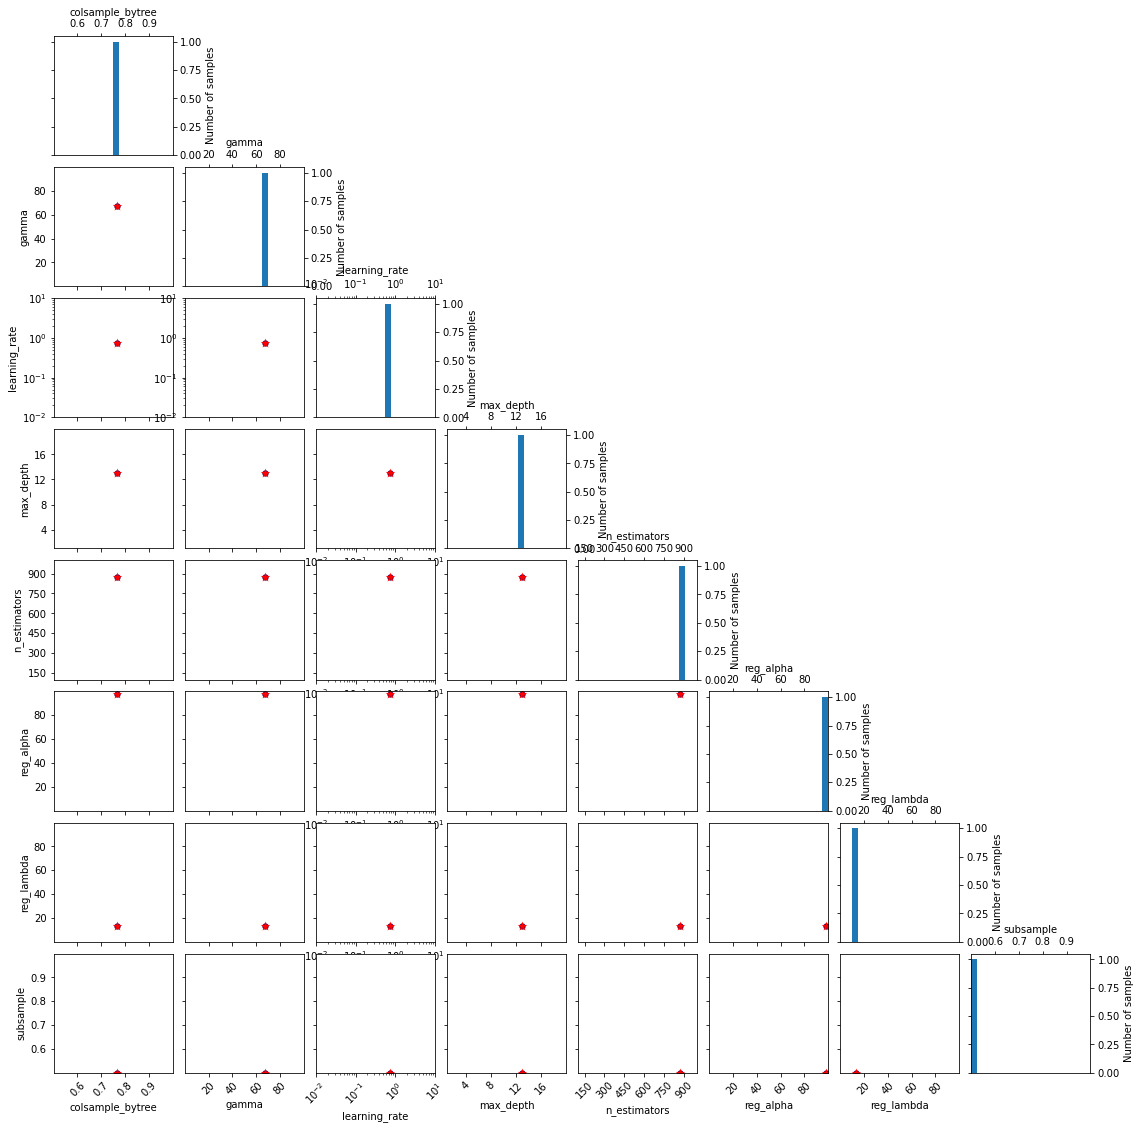

In [28]:
plots.plot_evaluations(best_params.optimizer_results_[0])
plt.show()

In [29]:
# started running at 8pm
from skopt import space, plots
# Visualize loss with respect to hyperparameters
plots.plot_objective(best_params.optimizer_results_[0])
plt.show()

ValueError: All integer values shouldbe greater than 0.000000

In [32]:
eval_set = [(X_train, y_train), (X_val, y_val)]

#### Default Model 

In [33]:
model_d = XGBClassifier() # default 
model_d.fit(X_train, y_train, early_stopping_rounds = 50, 
          eval_set = eval_set,
          eval_metric = ['error', 'logloss', 'auc'],
          verbose = True)

/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00006	validation_0-logloss:0.43754	validation_0-auc:0.96758	validation_1-error:0.00005	validation_1-logloss:0.43754	validation_1-auc:0.96547
[1]	validation_0-error:0.00005	validation_0-logloss:0.29637	validation_0-auc:0.96758	validation_1-error:0.00005	validation_1-logloss:0.29637	validation_1-auc:0.96547
[2]	validation_0-error:0.00005	validation_0-logloss:0.20742	validation_0-auc:0.96758	validation_1-error:0.00005	validation_1-logloss:0.20741	validation_1-auc:0.96547
[3]	validation_0-error:0.00005	validation_0-logloss:0.14791	validation_0-auc:0.96758	validation_1-error:0.00005	validation_1-logloss:0.14790	validation_1-auc:0.96547
[4]	validation_0-error:0.00005	validation_0-logloss:0.10672	validation_0-auc:0.98414	validation_1-error:0.00005	validation_1-logloss:0.10671	validation_1-auc:0.97925
[5]	validation_0-error:0.00005	validation_0-logloss:0.07761	validation_0-auc:0.98414	validation_1-error:0.00005	validation_1-logloss:0.07761	validation_1-auc:0.97925
[6]	

[50]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.99984
[51]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.99984
[52]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.99985
[53]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.99984
[54]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.99984
[55]	validation_0-error:0.00002	validation_0-logloss:0.00009	validation_0-auc:0.99998	validation_1-error:0.00005	validation_1-logloss:0.00020	validation_1-auc:0.9998

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
y_pred = model_d.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

print(f1_score, precision_score, recall_score)

[[1861867      42]
 [     61     438]]
0.8947906026557712 0.9125 0.8777555110220441


#### real1 

In [65]:
# try on dataset real1 40% 
model1 = XGBClassifier(colsample_bytree =  0.7643458710377254,
                      gamma = 5.789784370295127,
                      learning_rate = 0.10637763908757622,
                      max_depth = 5,
                      n_estimators = 316,
                      reg_alpha = 34.21270253201294,
                      reg_lambda = 64,
                      subsample = 0.7042865059246077)

In [66]:
# with early stopping
model1.fit(X_train, y_train, early_stopping_rounds = 50, 
          eval_set = eval_set,
          eval_metric = ['error', 'logloss', 'auc'],
          verbose = True)


/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00007	validation_0-logloss:0.59249	validation_0-auc:0.92689	validation_1-error:0.00006	validation_1-logloss:0.59249	validation_1-auc:0.94132
[1]	validation_0-error:0.00007	validation_0-logloss:0.51109	validation_0-auc:0.97726	validation_1-error:0.00007	validation_1-logloss:0.51108	validation_1-auc:0.98264
[2]	validation_0-error:0.00008	validation_0-logloss:0.44391	validation_0-auc:0.97734	validation_1-error:0.00006	validation_1-logloss:0.44390	validation_1-auc:0.98271
[3]	validation_0-error:0.00008	validation_0-logloss:0.38764	validation_0-auc:0.97734	validation_1-error:0.00006	validation_1-logloss:0.38762	validation_1-auc:0.98271
[4]	validation_0-error:0.00008	validation_0-logloss:0.33995	validation_0-auc:0.97734	validation_1-error:0.00006	validation_1-logloss:0.33993	validation_1-auc:0.98271
[5]	validation_0-error:0.00007	validation_0-logloss:0.29917	validation_0-auc:0.97734	validation_1-error:0.00006	validation_1-logloss:0.29915	validation_1-auc:0.98271
[6]	

[50]	validation_0-error:0.00008	validation_0-logloss:0.00247	validation_0-auc:0.99907	validation_1-error:0.00006	validation_1-logloss:0.00242	validation_1-auc:0.99634
[51]	validation_0-error:0.00008	validation_0-logloss:0.00226	validation_0-auc:0.99907	validation_1-error:0.00006	validation_1-logloss:0.00221	validation_1-auc:0.99634
[52]	validation_0-error:0.00008	validation_0-logloss:0.00206	validation_0-auc:0.99907	validation_1-error:0.00006	validation_1-logloss:0.00202	validation_1-auc:0.99634
[53]	validation_0-error:0.00008	validation_0-logloss:0.00189	validation_0-auc:0.99908	validation_1-error:0.00006	validation_1-logloss:0.00184	validation_1-auc:0.99635
[54]	validation_0-error:0.00008	validation_0-logloss:0.00173	validation_0-auc:0.99907	validation_1-error:0.00006	validation_1-logloss:0.00168	validation_1-auc:0.99632
[55]	validation_0-error:0.00008	validation_0-logloss:0.00159	validation_0-auc:0.99908	validation_1-error:0.00006	validation_1-logloss:0.00154	validation_1-auc:0.9963

[100]	validation_0-error:0.00007	validation_0-logloss:0.00032	validation_0-auc:0.99980	validation_1-error:0.00006	validation_1-logloss:0.00027	validation_1-auc:0.99980
[101]	validation_0-error:0.00007	validation_0-logloss:0.00032	validation_0-auc:0.99980	validation_1-error:0.00006	validation_1-logloss:0.00026	validation_1-auc:0.99980
[102]	validation_0-error:0.00007	validation_0-logloss:0.00032	validation_0-auc:0.99980	validation_1-error:0.00006	validation_1-logloss:0.00026	validation_1-auc:0.99980
[103]	validation_0-error:0.00007	validation_0-logloss:0.00031	validation_0-auc:0.99979	validation_1-error:0.00006	validation_1-logloss:0.00026	validation_1-auc:0.99980
[104]	validation_0-error:0.00007	validation_0-logloss:0.00031	validation_0-auc:0.99979	validation_1-error:0.00006	validation_1-logloss:0.00026	validation_1-auc:0.99980
[105]	validation_0-error:0.00007	validation_0-logloss:0.00031	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00026	validation_1-auc:

[149]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:0.99981
[150]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:0.99981
[151]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:0.99981
[152]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:0.99981
[153]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:0.99981
[154]	validation_0-error:0.00007	validation_0-logloss:0.00030	validation_0-auc:0.99978	validation_1-error:0.00006	validation_1-logloss:0.00024	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7643458710377254, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.789784370295127, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10637763908757622, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=316, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [67]:
# trained 2 hrs
y_pred = model1.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

print(f1_score, precision_score, recall_score)

[[1861877      32]
 [     88     411]]
0.8726114649681529 0.927765237020316 0.8236472945891784


In [38]:
# trained 30 minutes
y_pred = model1.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

print(f1_score, precision_score, recall_score)

[[1861889      20]
 [    125     374]]
0.8376259798432251 0.949238578680203 0.749498997995992


In [68]:
# trying out model2 with only candidates checked
# try on dataset real1 40% 
model2 = XGBClassifier(colsample_bytree =  0.7643458710377254,
                      gamma = 5.789784370295127,
                      learning_rate = 0.10637763908757622)
model2.fit(X_train, y_train, early_stopping_rounds = 50, 
          eval_set = eval_set,
          eval_metric = ['error', 'logloss', 'auc'],
          verbose = True)

/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/ting/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.00007	validation_0-logloss:0.59244	validation_0-auc:0.92689	validation_1-error:0.00006	validation_1-logloss:0.59244	validation_1-auc:0.94133
[1]	validation_0-error:0.00007	validation_0-logloss:0.51101	validation_0-auc:0.96000	validation_1-error:0.00006	validation_1-logloss:0.51100	validation_1-auc:0.96890
[2]	validation_0-error:0.00007	validation_0-logloss:0.44381	validation_0-auc:0.98712	validation_1-error:0.00006	validation_1-logloss:0.44380	validation_1-auc:0.98269
[3]	validation_0-error:0.00006	validation_0-logloss:0.38751	validation_0-auc:0.98714	validation_1-error:0.00006	validation_1-logloss:0.38750	validation_1-auc:0.98270
[4]	validation_0-error:0.00006	validation_0-logloss:0.33981	validation_0-auc:0.98714	validation_1-error:0.00005	validation_1-logloss:0.33980	validation_1-auc:0.98270
[5]	validation_0-error:0.00006	validation_0-logloss:0.29903	validation_0-auc:0.98714	validation_1-error:0.00005	validation_1-logloss:0.29902	validation_1-auc:0.98270
[6]	

[50]	validation_0-error:0.00005	validation_0-logloss:0.00230	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00229	validation_1-auc:0.99985
[51]	validation_0-error:0.00005	validation_0-logloss:0.00209	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00208	validation_1-auc:0.99985
[52]	validation_0-error:0.00005	validation_0-logloss:0.00189	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00188	validation_1-auc:0.99985
[53]	validation_0-error:0.00005	validation_0-logloss:0.00172	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00171	validation_1-auc:0.99985
[54]	validation_0-error:0.00005	validation_0-logloss:0.00157	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00156	validation_1-auc:0.99985
[55]	validation_0-error:0.00005	validation_0-logloss:0.00143	validation_0-auc:0.99917	validation_1-error:0.00005	validation_1-logloss:0.00142	validation_1-auc:0.9998

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7643458710377254, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.789784370295127, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10637763908757622, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [69]:
y_pred = model2.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

print(f1_score, precision_score, recall_score)

[[1861871      38]
 [     61     438]]
0.8984615384615384 0.9201680672268907 0.8777555110220441


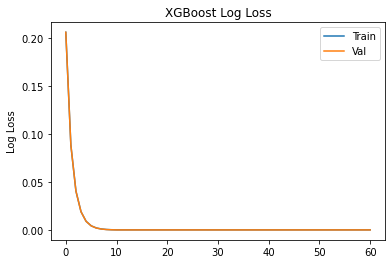

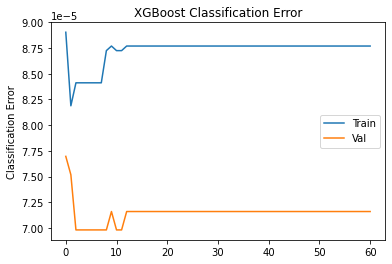

In [39]:
# retrieve model performance 
results = model1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
from matplotlib import pyplot
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

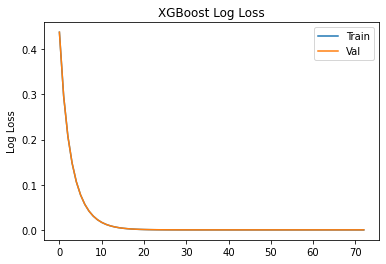

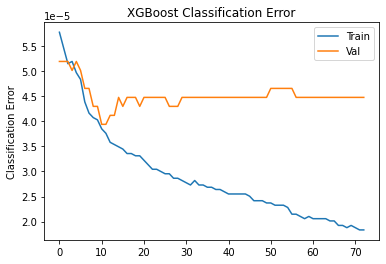

In [40]:
# retrieve model performance 
results = model_d.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
from matplotlib import pyplot
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

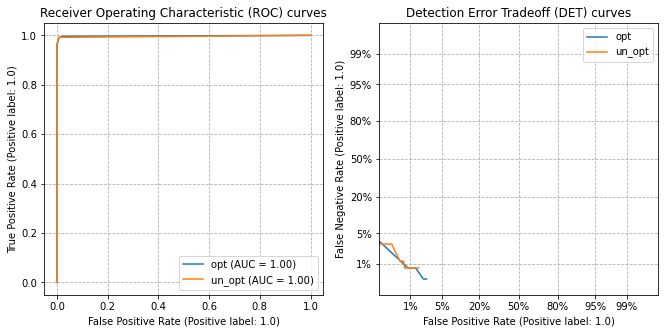

In [41]:
# model evaluation 
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(model1, X_test, y_test, ax=ax_roc, name='opt')
DetCurveDisplay.from_estimator(model1, X_test, y_test, ax=ax_det, name='opt')

RocCurveDisplay.from_estimator(model_d, X_test, y_test, ax=ax_roc, name="default")
DetCurveDisplay.from_estimator(model_d, X_test, y_test, ax=ax_det, name="default")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### test on real2

In [42]:
# test on real2Part1
real2_varscan_sub = allel.vcf_to_dataframe("real2_part1/real2_varscan_chr1to5.vcf.gz", fields = final_target_features['varscan'])
real2_freebayes_sub = allel.vcf_to_dataframe("real2_part1/real2_freebayes_chr1to5.vcf.gz", fields = final_target_features['freebayes'])
real2_mutect2_sub = allel.vcf_to_dataframe("real2_part1/real2_mutect_chr1to5.vcf.gz", fields =final_target_features['mutect2'])
real2_vardict_sub = allel.vcf_to_dataframe("real2_part1/real2_vardict_chr1to5.vcf.gz", fields = final_target_features['vardict'])

In [43]:
# subsetting for snp = True 
varscan_sub2 = real2_varscan_sub[real2_varscan_sub.is_snp == True]
freebayes_sub2 = real2_freebayes_sub[real2_freebayes_sub.is_snp == True]
mutect2_sub2 = real2_mutect2_sub[real2_mutect2_sub.is_snp == True]
vardict_sub2 = real2_vardict_sub[real2_vardict_sub.is_snp == True]

In [44]:
lst_dfs = [varscan_sub2,freebayes_sub2,mutect2_sub2,vardict_sub2]
suffix = ['vs','fb','m2','vd']
keep_same = {'CHROM', 'POS'}
i =0 
for df in lst_dfs:
    df.columns = ['{}{}'.format(c, '' if c in keep_same else '_'+suffix[i]) for c in df.columns]
    i += 1
lst_dfs

[      SOMATIC_vs        ID_vs    SPV_vs  FILTER_PASS_vs CHROM        POS  \
 4          False  rs145599635  0.572130           False     1      10234   
 5          False  rs148908337  0.431760           False     1      10248   
 6          False  rs199706086  0.055549           False     1      10250   
 8          False  rs145427775  0.627830           False     1      10291   
 9          False  rs112750067  0.963350           False     1      10327   
 ...          ...          ...       ...             ...   ...        ...   
 2911       False   rs11491460  0.111190           False     5  180902947   
 2913       False            .  0.514320           False     5  180904061   
 2915       False  rs375809536  0.462720           False     5  180904931   
 2916       False            .  0.185930           False     5  180905050   
 2917       False            .  0.165450           False     5  180905165   
 
       is_snp_vs  
 4          True  
 5          True  
 6          True 

In [45]:
merged_df2 = reduce(lambda left, right: pd.merge(left, right,on =['CHROM', 'POS'],
                                            how = 'outer', suffixes = ('', '')),lst_dfs)
merged_df2 = merged_df2.drop(['is_snp_vd','is_snp_fb','is_snp_m2','is_snp_vs'], axis=1)

In [46]:
##  function to get y labels
truth_labels = pd.read_csv("real2_part1/real2_truth_chr1to5.bed", sep = "\t", names = ['Chromo', 'start', 'end'])
print(list(set(truth_labels.start == truth_labels.end) )) # the start and end position are the same 
truth_labels = truth_labels[['Chromo', 'start']]
truth_labels['Chromo'] = truth_labels['Chromo'].astype(str)
truth_labels['truth'] = 1
sub_truth= truth_labels.rename(columns = {'Chromo':'CHROM', 'start':'POS'})

[True]


In [47]:
# combine dataset 
combined2 = merged_df2.merge(sub_truth, on=['CHROM','POS'], how = 'left' )
combined2['truth'].fillna(0, inplace = True)

In [51]:
X = combined2[combined2.columns[~combined2.columns.isin(['truth','POS','CHROM'])]]

y = combined2['truth'] 

In [53]:
# ordinal encoding for REF and ALT
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X)
new_X2 = enc.transform(X)
newn_X2 = pd.DataFrame(new_X2, columns = X.columns)

In [73]:
# model 2 (only with the checked candidates)
y_pred_2 = model2.predict(newn_X2)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
print(confusion_matrix(y,y_pred_2))

f1_score = metrics.f1_score(y_true = y, y_pred = y_pred_2)
precision_score = metrics.precision_score(y_true = y, y_pred = y_pred_2)
recall_score = metrics.recall_score(y_true = y, y_pred = y_pred_2)

print(f1_score, precision_score, recall_score)

[[1654743       1]
 [    162     300]]
0.7863695937090434 0.9966777408637874 0.6493506493506493


In [61]:
# default model 
y_pred_2 = model_d.predict(newn_X2)
print(confusion_matrix(y,y_pred_2))

f1_score = metrics.f1_score(y_true = y, y_pred = y_pred_2)
precision_score = metrics.precision_score(y_true = y, y_pred = y_pred_2)
recall_score = metrics.recall_score(y_true = y, y_pred = y_pred_2)

print(f1_score, precision_score, recall_score)

[[1654741       3]
 [    143     319]]
0.8137755102040817 0.9906832298136646 0.6904761904761905


In [56]:
# opt model (30 mins training)
y_pred_2 = model1.predict(newn_X2)
# predicted all zeros for some reason wtf
print(confusion_matrix(y,y_pred_2))

f1_score = metrics.f1_score(y_true = y, y_pred = y_pred_2)
precision_score = metrics.precision_score(y_true = y, y_pred = y_pred_2)
recall_score = metrics.recall_score(y_true = y, y_pred = y_pred_2)

print(f1_score, precision_score, recall_score)

[[1654744       0]
 [    462       0]]


/Users/ting/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0 0.0 0.0


In [ ]:
# trying early stopping when after hyperparameter tuning 

In [ ]:
# trying with early stopping 
# Wrapping everything up into the Bayesian optimizer
from time import time
from sklearn.model_selection import train_test_split

# Further split training dataset into Train and Validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)


fit_params = {
    'early_stopping_rounds':10, 
    'eval_metric':'accuracy', #change?
    'eval_set':[(X_val, y_val)]
}

baye_opt = BayesSearchCV(
    estimator = clf,
    search_spaces = search_spaces,
    scoring = 'roc_auc',
    cv = cv_strategy,
    n_iter=120,                                       # max number of trials
    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
    n_jobs=-1,                                         # number of jobs
    #iid=False,                                        # if not iid it optimizes on the cv score
    # return_train_score=False,
    refit=False,
    optimizer_kwargs={'base_estimator': 'GP'},  # optmizer parameters: we use Gaussian Process (GP)
    fit_params = fit_params,
    random_state=0) 



In [ ]:
model = XGBClassifier(colsample_bytree =  0.629185830986374,
                      gamma = 97.89036584265726,
                      learning_rate = 0.9093539899332748,
                      max_depth = 13,
                      n_estimators = 336,
                      reg_alpha = 16.27824954246273,
                      reg_lambda = 77,
                      subsample = 0.6208182237087633)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)

In [ ]:
# Evaluate XGBoost model with Learning Curves 
eval_set = [(X_train, y_train), (X_val, y_val)]

model.fit(X_train, y_train, early_stopping_rounds = 20,
          eval_set= eval_set, # [(X_val, y_val)],
          eval_metric = ['error', 'log']
          
         verbose = True)

In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

In [ ]:
# plot log loss
from matplotlib import pyplot
fig.ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

f1_score

In [ ]:
XGBoost_classifier took 2710.30 seconds,  candidates checked: 1, best CV score: 0.999 ± 0.000
Best parameters:
OrderedDict([('colsample_bytree', 0.7654820824760737),
             ('gamma', 67.60795088801528),
             ('learning_rate', 0.6264826551031426),
             ('max_depth', 14),
             ('n_estimators', 873),
             ('reg_alpha', 98.05562626781331),
             ('reg_lambda', 13),
             ('subsample', 0.10147326463495382)])


In [25]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (1 hours)

best_param4s = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_classifier took 27373.99 seconds,  candidates checked: 2, best CV score: 0.999 ± 0.002
Best parameters:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])



In [ ]:
XGBoost_classifier took 27373.99 seconds,  candidates checked: 2, best CV score: 0.999 ± 0.002
Best parameters:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])

In [ ]:
OrderedDict([('colsample_bytree', 0.629185830986374),
             ('gamma', 97.89036584265726),
             ('learning_rate', 0.9093539899332748),
             ('max_depth', 13),
             ('n_estimators', 336),
             ('reg_alpha', 16.27824954246273),
             ('reg_lambda', 77),
             ('subsample', 0.6208182237087633)])

In [30]:
model = XGBClassifier(colsample_bytree =  0.629185830986374,
                      gamma = 97.89036584265726,
                      learning_rate = 0.9093539899332748,
                      max_depth = 13,
                      n_estimators = 336,
                      reg_alpha = 16.27824954246273,
                      reg_lambda = 77,
                      subsample = 0.6208182237087633, 
                      eval_metric = 'auc')

In [ ]:
# Transferring the best parameters to our basic regressor
# reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist', **best_params)
#clf = XGBClassifier(random_state=0, 
#                    booster='gbtree', 
#                    eval_metric = 'auc',
 #                   objective='binary:logistic', 
  #                  tree_method='approx', verbosity = 0)#

In [ ]:
model.fit(X_train, y_train)

In [28]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred))

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_pred)
precision_score = metrics.precision_score(y_true = y_test, y_pred = y_pred)
recall_score = metrics.recall_score(y_true = y_test, y_pred = y_pred)

f1_score

[[1396415      23]
 [     89     279]]


0.8328358208955225

In [26]:
unoptimised_model = XGBClassifier()

In [27]:
unoptimised_model.fit(X_train, y_train, n_jobs = -1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
y_pred_u = unoptimised_model.predict(X_test)
from sklearn.metrics import classification_report
from sklearn import metrics
print(confusion_matrix(y_test,y_pred_u))

f1_score_u = metrics.f1_score(y_true = y_test, y_pred = y_pred_u)
precision_score_u = metrics.precision_score(y_true = y_test, y_pred = y_pred_u)
recall_score_u = metrics.recall_score(y_true = y_test, y_pred = y_pred_u)

f1_score_u


[[1396401      37]
 [     46     322]]


0.8858321870701513

In [24]:
y_pred = model.predict(X_test)
# evaluate model performance # for syn1 dataset 
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1396415      23]
 [     89     279]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.92      0.76      0.83       368

    accuracy                           1.00   1396806
   macro avg       0.96      0.88      0.92   1396806
weighted avg       1.00      1.00      1.00   1396806



In [ ]:
 search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100)}

In [21]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

In [ ]:
# Running the optimizer # using the first search space

overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (1 hours)

best_param4s = report_perf(baye_opt, X_train, y_train,'XGBoost_classifier', 
                          callbacks=[overdone_control, time_limit_control])

In [ ]:
The value of AUC using default hyperparameter values is 0.68, which is not bad
The tuned model AUC is 0.7416419 which is much higher than the model with default paraeters. Yeah, we have improved the model by tuning the parameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

In [ ]:
We can now get the folds using our train set. I use a repeated k-fold to get more score results:

In [ ]:
cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]

In [ ]:
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train])
    dval   = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))